# Problem Tanımı
-> Bir havayolu şirketine gelen tweetlerin sentiment analysis'ini yapmak.

Bilgiler:

-> Tweetler sınıflara zaten ayrılmış durumda: pozitif, negatif ve nötr şeklinde. Biz sadece pozitif ve negativ sınıflandırması için bir model eğitiyoruz. 

-> Model: Multinomial Bayes



# Data Fetch #

In [23]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df = pd.read_csv('/content/drive/MyDrive/Tweets.csv')

In [26]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Data Preparation #


In [28]:
# neutral olanlar çıkarılıyor çünkü pozitif ve negatif classification yapılacak
tw=df[df['airline_sentiment']!='neutral']
# indexler resetleniyor çıkarıldıktan sonra
tw.reset_index(inplace=True,drop=True)


In [12]:
tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      11541 non-null  int64  
 1   airline_sentiment             11541 non-null  object 
 2   airline_sentiment_confidence  11541 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     9508 non-null   float64
 5   airline                       11541 non-null  object 
 6   airline_sentiment_gold        37 non-null     object 
 7   name                          11541 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 11541 non-null  int64  
 10  text                          11541 non-null  object 
 11  tweet_coord                   838 non-null    object 
 12  tweet_created                 11541 non-null  object 
 13  t

In [29]:
# pozitifler 1 class'ında, negatifler 0 
def partition(x):
    if x =='positive':
        return 1
    return 0

In [30]:
actualSentiment = tw['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
tw['Sentiment'] = positiveNegative


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
tw['Sentiment'].value_counts()
# 9178 negatif, 2363 pozitif tweet

0    9178
1    2363
Name: Sentiment, dtype: int64

In [21]:
tweets=[word_tokenize(tweet) for tweet in tw['text']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])
# tweet kelimeleri ayrılıp her tweet kelime arraylerinden oluşacak şekilde docs'ta saklanıyor

In [22]:
docs

[['@',
  'VirginAmerica',
  'plus',
  'you',
  "'ve",
  'added',
  'commercials',
  'to',
  'the',
  'experience',
  '...',
  'tacky',
  '.'],
 ['@',
  'VirginAmerica',
  'it',
  "'s",
  'really',
  'aggressive',
  'to',
  'blast',
  'obnoxious',
  '``',
  'entertainment',
  "''",
  'in',
  'your',
  'guests',
  "'",
  'faces',
  '&',
  'amp',
  ';',
  'they',
  'have',
  'little',
  'recourse'],
 ['@',
  'VirginAmerica',
  'and',
  'it',
  "'s",
  'a',
  'really',
  'big',
  'bad',
  'thing',
  'about',
  'it'],
 ['@',
  'VirginAmerica',
  'seriously',
  'would',
  'pay',
  '$',
  '30',
  'a',
  'flight',
  'for',
  'seats',
  'that',
  'did',
  "n't",
  'have',
  'this',
  'playing',
  '.',
  'it',
  "'s",
  'really',
  'the',
  'only',
  'bad',
  'thing',
  'about',
  'flying',
  'VA'],
 ['@',
  'VirginAmerica',
  'yes',
  ',',
  'nearly',
  'every',
  'time',
  'I',
  'fly',
  'VX',
  'this',
  '“',
  'ear',
  'worm',
  '”',
  'won',
  '’',
  't',
  'go',
  'away',
  ':',
  ')'],
 

In [32]:
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)

In [35]:
stops # içinde hem punctuations hem de stopwords var

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [33]:
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


## Data Cleaning ##


In [36]:
# şimdi data temizlenecek
# pos_tag kelimeleri türlerine ayırır: isim, zamir, sıfat, zarf vs
# stopwords(the, a, with gibi keliemeler), noktalama işaretleri temizlenecek
# ve lemmatize ile her docs elementi (yani her bir tweetteki keliemeler) köklerine indirgeniyor (better -> good oluyo gibi)
from nltk import pos_tag 
from nltk.stem import WordNetLemmatizer


In [37]:
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops: # eğer kelime stopword değilse
            pos=pos_tag(word)         # 
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1])) # lemmatize(kelimeler, kelime tag'leri)
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1


In [38]:
docs=[ clean(doc) for doc in docs]

In [49]:
tw['text'][:5]

0    @VirginAmerica plus you've added commercials t...
1    @VirginAmerica it's really aggressive to blast...
2    @VirginAmerica and it's a really big bad thing...
3    @VirginAmerica seriously would pay $30 a fligh...
4    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

In [50]:
docs[:5]

[b"virginamerica plus 've added commercial experience ... tacky",
 b"virginamerica 's really aggressive blast obnoxious `` entertainment '' guest face amp little recourse",
 b"virginamerica 's really big bad thing",
 b"virginamerica seriously would pay 30 flight seat n't playing 's really bad thing flying va",
 b'virginamerica yes nearly every time fly vx \xe2\x80\x9c ear worm \xe2\x80\x9d \xe2\x80\x99 go away']

In [51]:
# train, test ve validation setlere ayrılıyor
X = np.array(docs)
Y = np.array(tw['Sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.2, random_state=0)

In [58]:
Y[:5] # label'lar: 1 pozitif, 0 negatif tweetler için

array([1, 0, 0, 0, 1])

In [59]:
X[:5]

array([b"virginamerica plus 've added commercial experience ... tacky",
       b"virginamerica 's really aggressive blast obnoxious `` entertainment '' guest face amp little recourse",
       b"virginamerica 's really big bad thing",
       b"virginamerica seriously would pay 30 flight seat n't playing 's really bad thing flying va",
       b'virginamerica yes nearly every time fly vx \xe2\x80\x9c ear worm \xe2\x80\x9d \xe2\x80\x99 go away'],
      dtype='|S202')

In [62]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (7732,) (7732,)
X_test, Y_test (3809,) (3809,)
X_tr, Y_tr (6185,) (6185,)
X_cv, Y_cv (1547,) (1547,)


# Hyperparameter Tuning #


## MultinomialNB ## 

 
### Multinomial NB

Multinomial NB: olasılıklar bir model ve bayes teoremine dayanıyor:
P(A|B) = P(A) * P(B|A)/P(B)

MNB bir text'in tag'ini bulmaya çalışır. Bu örnekte pozitif ve negatif tag'lere ayırmaya çalışacak. Her text'in yani tweet'in bu iki sınıfa aitliğini olasılık üzerinden hesaplayıp hangisi daha yüksekse o sınıfa ekliyor

hyperparameter tuning için:
1. farklı alpha değerleri denenip best alpha bulunur
2. farklı vectorizationlar denenir

kullanılan measure'lar: 
-auc roc
-f1 score
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [63]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import  MultinomialNB

In [73]:
def mulnb(X_train,X_cv,Y_train,Y_cv): # multinomial nb için fonksiyon
    best_alpha=0
    max_roc_auc=-1    # tahminleri %100 doğru olan bir modelin auc score'u 1 olur, tam tersi için auc score'u 0
    pred_cv = []
    pred_train = []
    alpha=[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005] # deneneck alpha değerleri
    for i in alpha[-10:]:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train) # fit yapılıyor
        probs = mulbnb.predict_proba(X_cv) # tahminler (olasılık üzerinden) 
        prob = mulbnb.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_cv)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i
    print(f"\n Best alpha Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [68]:
AUC,F1=[],[]
def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    bnb = MultinomialNB(optimal_alpha,fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    probs = bnb.predict_proba(X_test) 
    # positif sınıf olasılıkları tutulur
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    AUC.append(round(roc_auc_score(Y_test,probs),2))
    # roc curve hesaplanır
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
  
    plt.plot([0, 1], [0, 1], linestyle='--')
    # roc curve grafiği:
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    prediction=bnb.predict(X_test)
    cm=confusion_matrix(Y_test,prediction)
    cm1 = pd.DataFrame(cm , index = ['positive','negative'] , columns = ['positive','negative'])
    plt.figure(figsize = (10,10))
    ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    ax.set(xlabel="Actual Sentiment", ylabel = "Predicted Sentiment")
    # f1 score ve hamming loss kullanılır performans ölçümü için
    print("f1 score for data :",metrics.f1_score(Y_test, prediction))
    F1.append(round(metrics.f1_score(Y_test, prediction),2))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

### Vectorization
-> Vectorization ya da Feature Extraction, ML algoritmalarına kelimeleri input olarak vermek için yapılır. Kelimeler sayılara dönüştürülür. 

-> CountVectorizer: kelimeleri frekanslarına göre ayırır (yani text'teki bulunma sayıları)



In [69]:
# bag of word modeli oluyor bundan sonrası:
# harf ve sayı dışındaki karakterler ve stopword'ler temizlenir
# ve bir matrix çıkar ortaya: her satır bir text'e işaret ediyor, her sütun ise sözlükten bir kelime, yani tweetlerdeki kelimeler aslında
count_vect = CountVectorizer(ngram_range=(1,2))
bow= count_vect.fit(X_tr)
bow_train = bow.transform(X_tr)
sum_words = bow_train.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in bow.vocabulary_.items()] # kelime frekansları hesaplanır
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)                # frekanslarına göre en çok geçen kelimelerden en aza kadar sıralanır
print("Top 20 words with their frequencies in training set are",words_freq[:20])  # ilk 20 en çok geçen kelime
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

Top 20 words with their frequencies in training set are [('united', 1846), ('flight', 1751), ('usairways', 1385), ('americanair', 1288), ('southwestair', 984), ('jetblue', 904), ('hour', 617), ('get', 591), ('service', 520), ('cancelled', 517), ('customer', 513), ('thanks', 506), ('time', 435), ('bag', 394), ('call', 386), ('help', 378), ('plane', 375), ('co', 340), ('http', 338), ('http co', 338)]
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [70]:
# daha verimli bir sonuç için normalization yapılır, yani kelime frekansları aynı skala içine alınır
from sklearn import preprocessing 
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


100  ------>  0.8119084861986697
50  ------>  0.8268131856556752
10  ------>  0.8584027218193213
5  ------>  0.8723251857820754
1  ------>  0.9040911556672092
0.5  ------>  0.9170182174400783
0.1  ------>  0.9373238954459032
0.05  ------>  0.9395411669905674
0.01  ------>  0.9349933903187921
0.005  ------>  0.9311724152459803

 Best alpha Value 0.05 with highest roc_auc Score is 0.9395411669905674


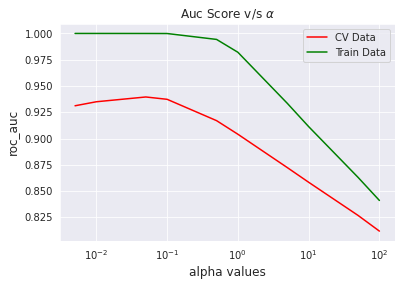

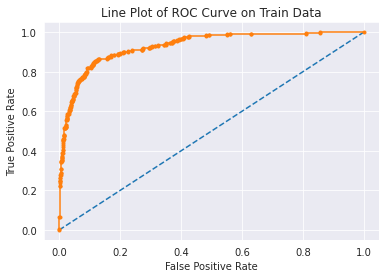

In [71]:
mulnb(bow_train,bow_cv,Y_tr,Y_cv) # modelin çalıştığı kısım -> en iyi roc_auc score elde eden alpha değeri 0.05 çıkıyor 
# en iyi roc_auc değerleri 1 ve 0.005 alpha değerleri arasında elde ediliyor 

AUC Score 0.9511475432969427


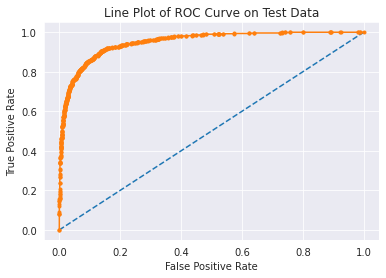

f1 score for data : 0.6926677067082684
hamming loss for data: 0.1034392228931478
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      3008
           1       0.92      0.55      0.69       801

    accuracy                           0.90      3809
   macro avg       0.91      0.77      0.82      3809
weighted avg       0.90      0.90      0.89      3809



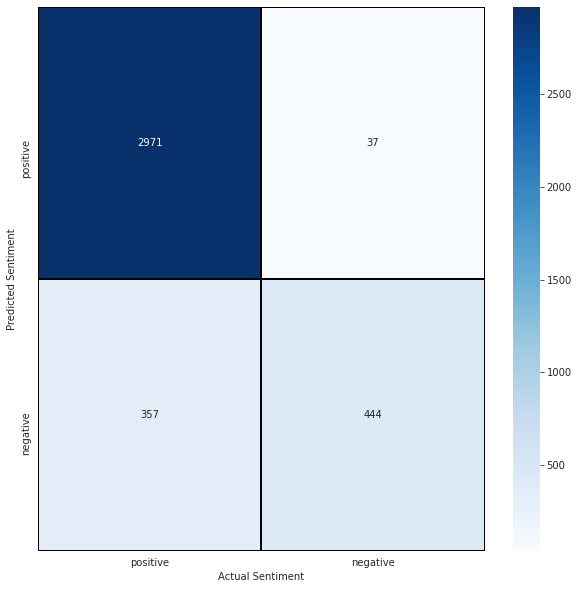

In [72]:
testing(bow_train,Y_tr,bow_test,Y_test,optimal_alpha=0.05) # testing için mulnb'den çıkan best alpha verilir
# f1 score precision ve recall için bir denge oluşturur
# precision: false positive azaldıkça artar yani negatiflerin pozitif olarak algılanmama değeri
# recall: false negative azaldıkça artar yani pozitiflein negatif olarak algılanmama değeri: fraud detection için verimli

### Farklı bir vectorizarion: tf-idf 

(Term Frequency - Inverse Document Frequency)

Term Frequency (TF): bir kelimenin dokümandaki tüm kelimelere oranı

Inverse Document Frequency (IDF): toplam doküman sayısının içinde belirli bir kelime geçen doküman sayısına oranının logaritması

-> sonuç olarak TF-IDF değeri bir kelimenin frekansı dokümanda arttıkça artar 

https://www.educative.io/edpresso/what-is-tf-idf


In [77]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10000:10010])                                                              
print("The type of vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

some sample features(unique words in the corpus) ['cheapslogannotmotto', 'cheat', 'cheat go', 'cheatcustomers', 'cheated', 'cheated sorry', 'check', 'check 10', 'check 24', 'check 3rd']
The type of vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [75]:
import pickle
pickle.dump(tf_idf_vect,open('transform.pkl','wb'))
from google.colab import files
files.download('transform.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
# 25 tf-idf featureleri
# çıkan sonuca göre genelde geri ödeme istenmiş: reimbursement
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(tfidf_train[1,:].toarray()[0],features,10)
top_tfidf

,feature,tfidf
0,asked reimbursement,0.272420
1,reimbursement something,0.272420
2,added account,0.272420
3,like mile,0.272420
4,mile added,0.272420
5,account told,0.260198
6,usairways asked,0.251525
7,something like,0.251525
8,reimbursement,0.244798
9,added,0.223903


In [78]:
#Normalize Data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [79]:
mulnb(tfidf_train,tfidf_cv,Y_tr,Y_cv)

100  ------>  0.8454782933855788
50  ------>  0.8505711712565769
10  ------>  0.870373881489206
5  ------>  0.8817815065859812
1  ------>  0.910284769293159
0.5  ------>  0.9217977279550015
0.1  ------>  0.9353910245269206
0.05  ------>  0.9343482222327556
0.01  ------>  0.9243757669600208
0.005  ------>  0.9192460223412492

 Best alpha Value 0.1 with highest roc_auc Score is 0.9353910245269206


AUC Score 0.9479098185114351


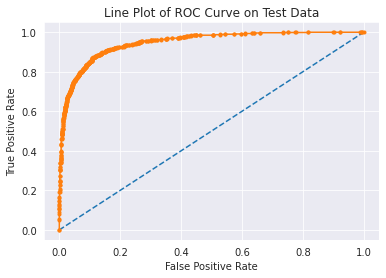

f1 score for data : 0.6465798045602607
hamming loss for data: 0.11394066684169073
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      3008
           1       0.93      0.50      0.65       801

    accuracy                           0.89      3809
   macro avg       0.91      0.74      0.79      3809
weighted avg       0.89      0.89      0.87      3809



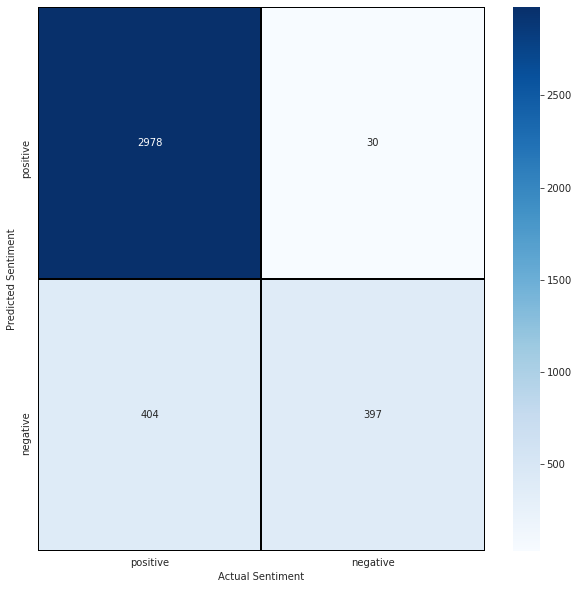

In [80]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_alpha=0.1)

In [ ]:
# tf-idf confusion matrixte faha fazla False Negatives çıkarıyor, bow tercih edilebilir

In [82]:
# MNB modelini BOW and TF-IDF vectorization ile kıyaslama:
from IPython.display import display

data = {'Category':['BOW Vectorization','TF-IDF Vectorization'],
        'AUC Score':AUC,
        'F1-Score':F1}
df = pd.DataFrame(data)

display(df)
# pek bir fark yok bow vectorization f1 score baz alınarak daha iyi denebilir

,Category,AUC Score,F1-Score
0,BOW Vectorization,0.95,0.69
1,TF-IDF Vectorization,0.95,0.65


In [87]:
pickle.dump(bnb,open('nlp_model.pkl','wb'))
from google.colab import files
files.download('nlp_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>